Task 1 (0.5 mark): Use the MeanShift algorithm for image segmentation.
Hint: Use MeanShift clustering from Scikit-learn.

Step 1. Once you have read the image into Numpy arrays, extract each colour channel (R, G, B) so you can use each as a variable for classification. To do this you will need to convert the colour matrices into a flattened vector as depicted below.

Step 2. Then you can use the new flattened colour sample matrix (e.g. 10,000 x 3 if your original image was 100 x 100) as your variable for classification.

Step 3. Use the MeanShift fit_predict() function to perform a clustering and save the cluster labels, which we want to observe.
Show the segmented image.

In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift
import sklearn

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


In [2]:
def calculate_DSC(im1, im2):
    n = np.count_nonzero(im1 & im2)
    a = np.count_nonzero(im1)
    b = np.count_nonzero(im2)
    return 2 * n / (a + b)

number of estimated clusters : 12


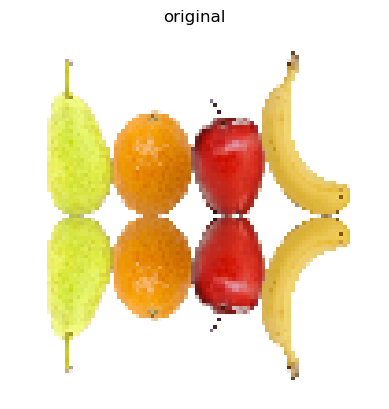

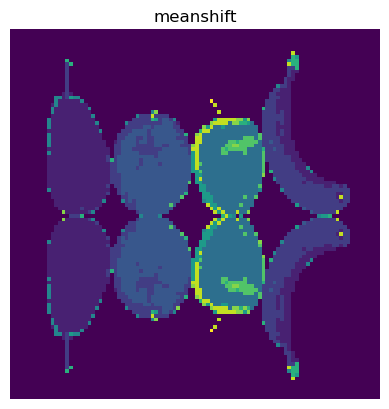

In [3]:
# Load file
file = 'Fruits.png'
img = cv.imread(file, cv.IMREAD_COLOR)
# make img 100x100
img = cv.resize(img, (100,100))

h, w, _ = img.shape

# Split image into color channels
# and stack into flattened vector
b, g, r = cv.split(img)
b = b.flatten()
g = g.flatten()
r = r.flatten()
arr = np.vstack([b,g,r]).T

# create meanshift clustering classifier
bandwidth = sklearn.cluster.estimate_bandwidth(arr, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# fit the meanshift classifier to the colour samples
labels = ms.fit_predict(arr)

# some data
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

#Reshape labels to display
ms_labels = labels.reshape(h, w)

#plot images
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('original')
plt.imshow(cv.cvtColor(img, cv.COLOR_RGB2BGR))
plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('meanshift')
plt.imshow(ms_labels)


Task 2 (1 mark): Use Watershed transformation for image segmentation.

Text(0.5, 1.0, 'Separated objects')

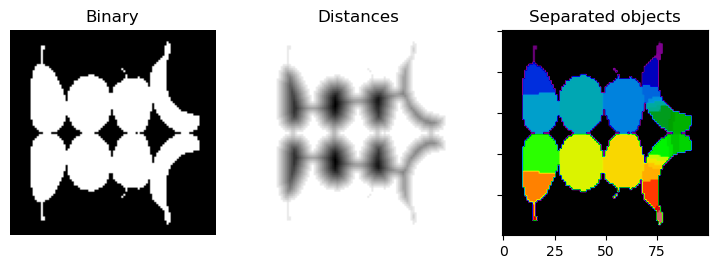

In [12]:
# convert to gray
img_grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
# Threshold image
ret, img_bin =cv.threshold(img_grey,250,255,cv.THRESH_BINARY)
img_bin = cv.bitwise_not(img_bin)

# Use watershed transformation (plot result of distance transform)
# Step 2 - Calculate the distance transform
distance = ndi.distance_transform_edt(img_bin)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img_bin)

#generate watershed markers
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
ws_labels = watershed(-distance, markers, mask=img_bin)

#plot images
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(0,2):
    ax[i].axis('off')

ax[0].imshow(img_bin, cmap=plt.cm.gray)
ax[0].set_title('Binary')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')



Task 3 (1 mark): Compare MeanShift and Watershed segmentation results.


In [13]:
def generate_mask_list(labels, l):
    out = []
    for i in l:
        if i == 0:
            continue
        out.append(labels == i)
    return out

def calculate_JSC(image,mask):
    # Threshold the image to create a binary mask
    _, image = cv.threshold(image, 128, 255, cv.THRESH_BINARY)
    _, mask = cv.threshold(mask, 128, 255, cv.THRESH_BINARY)

    # Calculate the intersection and union of the binary masks
    intersection = np.logical_and(image, mask)
    union = np.logical_or(image, mask)

    # Calculate the Jaccard Similarity Coefficient (JSC)
    jsc = np.sum(intersection) / np.sum(union)

    return jsc



# Generate list of MaskX.png images
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,9)]

# Generate list of unique MeanShift labels and corresponding label image masks
lbl_ms_unique = np.unique(ms_labels)
ms_masks = generate_mask_list(ms_labels, lbl_ms_unique)

# list of unique Watershed labels
lbl_ws_unique = np.unique(ws_labels)
ws_masks = generate_mask_list(ws_labels, lbl_ws_unique)

# for each mask
for each_mask in MaskX:
    img1 = cv.imread(each_mask, cv.IMREAD_GRAYSCALE)
    img1.resize(h,w)

    # Check JSC for each MeanShift label
    ms_JSC = [calculate_JSC(img1, mask) for mask in ms_masks]
    ms_JSC = max(ms_JSC)
    
    # Check DSC for each Watershed label
    ws_JSC = [calculate_JSC(img1, mask) for mask in ws_masks]
    ws_JSC = max(ws_JSC)

    print(f'[{img1}]  |  Meanshift: {ms_JSC:.4f}  |  Watershed: {ws_JSC:.4f}')

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'threshold'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'
